In [5]:
library(tictoc)
library(cmdstanr)
library(posterior)
library(bayesplot)
library(rstan)
library(splines)

  |======================================================================| 100%0.16 sec elapsed


Compiling Stan program...



Running MCMC with 1 chain...

Chain 1 WARNING: There aren't enough warmup iterations to fit the 
Chain 1          three stages of adaptation as currently configured. 
Chain 1          Reducing each adaptation stage to 15%/75%/10% of 
Chain 1          the given number of warmup iterations: 
Chain 1            init_buffer = 15 
Chain 1            adapt_window = 75 
Chain 1            term_buffer = 10 
Chain 1 Iteration:   1 / 200 [  0%]  (Warmup) 
Chain 1 Iteration:  50 / 200 [ 25%]  (Warmup) 
Chain 1 Iteration: 100 / 200 [ 50%]  (Warmup) 
Chain 1 Iteration: 101 / 200 [ 50%]  (Sampling) 
Chain 1 Iteration: 150 / 200 [ 75%]  (Sampling) 
Chain 1 Iteration: 200 / 200 [100%]  (Sampling) 
Chain 1 finished in 19.1 seconds.


Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following objects are masked from ‘package:posterior’:

    ess_bulk, ess_tail




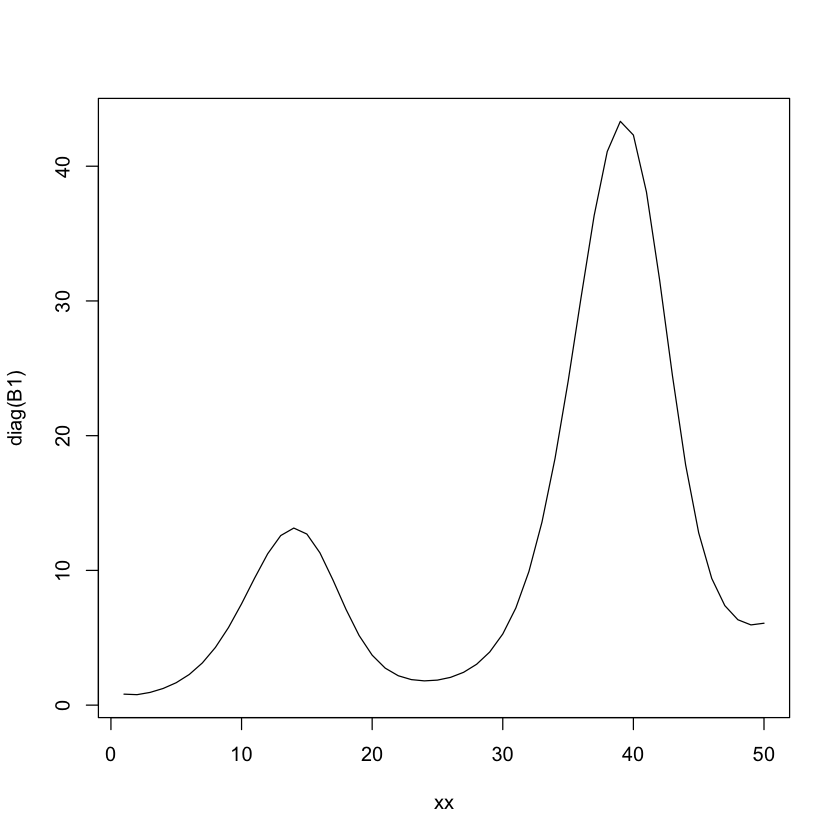

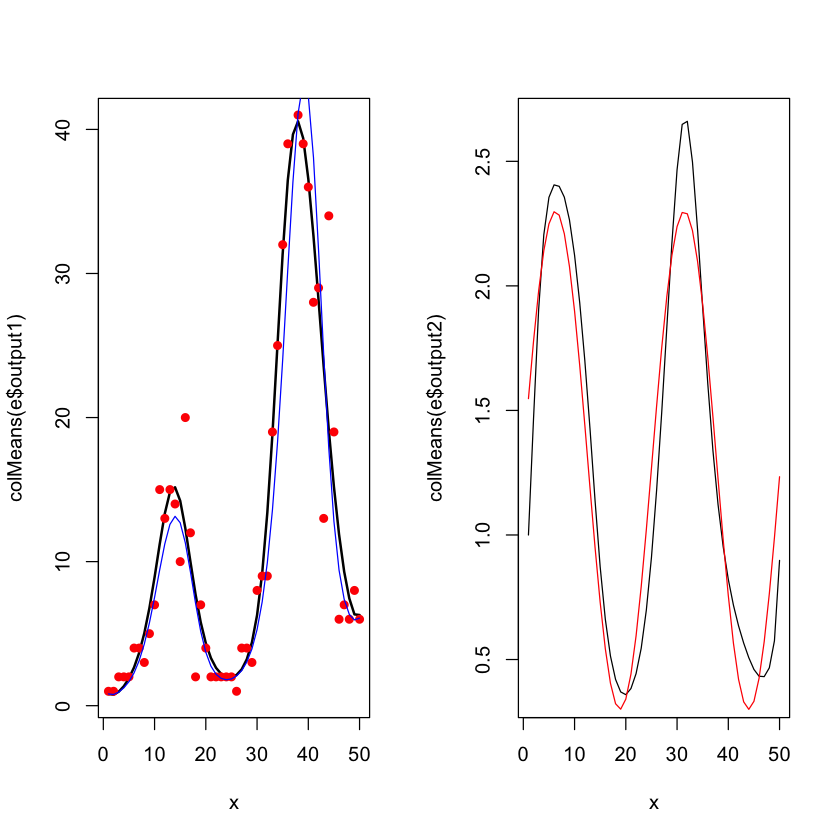

In [7]:
set.seed(123)
theta1 = 3
theta2 = 1
rbase = function(n) rgamma(n,theta1,theta2)
dbase = function(n) dgamma(n,theta1,theta2)
pbase = function(n) pgamma(n,theta1,theta2)

Rt = function(x){
  R0 + sin(0.25*x)
}
dx = 1
max_time <- 50
R0 <- 1.3
xx = seq(1,max_time,dx)
nn = length(xx)

g = dbase(xx)
g = g/sum(g)

A = matrix(0,nrow=nn,ncol=nn)
C = matrix(NA,nrow=nn,ncol=nn)
G = matrix(NA,nrow=nn,ncol=nn)
for(i in 1:nn){
  A[,i] = Rt(pmax(0,xx-xx[i]))
  C[i,] = g
  G[,i] = (1-cumsum(g))[i]

}
A[upper.tri(A)] <- 0

A2 = matrix(0,nrow=nn,ncol=nn)
R = Rt(xx)
for(i in 1:nn){
  for(j in 1:i)
    A2[,i] = R[i-j+1]
}

B1 = matrix(0,nrow=nn,ncol=nn)
B1[,1]=G[,1]
B1[,2]=G[,2]+C[,(2-1):1]*A[,1:(2-1)]*B1[,1:(2-1)]

#all further steps

tic()
pb <- txtProgressBar(min = 0, max = nn, style = 3)
for(i in 3:nn){
  convolution1=rowSums(C[,(i-1):1]*A[,1:(i-1)]*B1[,1:(i-1)],na.rm=T)

  B1[,i] = G[,i] + convolution1
  setTxtProgressBar(pb, i)
}
toc()
plot(xx,diag(B1),type='l')

x = xx
n = length(x)
response1=diag(B1) + rnorm(n,0,0.4*diag(B1))

b = 10
Basis = bs(x,df=b,degree=3)
file <- file.path('../stan/branching_process.stan')

mod <- cmdstan_model(file,cpp_options=list("STAN_NO_RANGE_CHECKS"=TRUE))

Truncation = 20
stan_data = list(N=n,prev=ceiling(response1),g=g,G=G,C=C,x=x,Basis=Basis,B=b,T=Truncation)

fit <- mod$sample(
  data = stan_data,
  chains = 1,
  parallel_chains = 1,
  refresh = 50,
  iter_sampling =100,
  iter_warmup=100
)
stanfit <- rstan::read_stan_csv(fit$output_files())
